# Biphenyl MM Energies

Adapted from: https://github.com/choderalab/fragmenter_data/blob/master/wbo-manuscript-figures/biphenyl_example/biphenyl_mm_energy.ipynb

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline

from functools import partial

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
from openeye import oechem, oedepict

from simtk.openmm import app
from simtk import openmm as mm
from simtk import unit
from simtk import openmm, unit

from fragmenter import torsions, chemi

from autograd import grad
from autograd import numpy as np

## Function definitions

In [3]:
# From Josh - constrained minimzation 

def compute_dihedral(xyz, indices):
    """Copied from mdtraj, except without calls to a non-python distance library,
    and assuming we dont have to deal with periodic stuff"""
    
    a,b,c,d = indices
    b1 = xyz[b] - xyz[a]
    b2 = xyz[c] - xyz[b]
    b3 = xyz[d] - xyz[c]
    
    c1 = np.cross(b2, b3) # bc x cd
    c2 = np.cross(b1, b2) # ab x bc

    p1 = np.sum(b1 * c1)
    p1 *= np.sum(b2 * b2) ** 0.5
    p2 = np.sum(c1 * c2)

    return np.arctan2(p1, p2)

def unflatten(flat_xyz):
    N = int(len(flat_xyz) / 3)
    return np.reshape(flat_xyz, (N, 3))

def set_positions(xyz, simulation):
    simulation.context.setPositions(xyz)
        
def get_energy(xyz, simulation):
    set_positions(xyz, simulation)
    U = simulation.context.getState(getEnergy=True).getPotentialEnergy()
    return U/U.unit

def get_forces(xyz, simulation):
    set_positions(xyz, simulation)
    F =  simulation.context.getState(getForces=True).getForces(asNumpy=True)
    return F/F.unit

def fxn_to_minimize(flat_xyz, simulation):
    return get_energy(unflatten(flat_xyz), simulation)

def jacobian_of_fxn(flat_xyz, simulation):
    return - get_forces(unflatten(flat_xyz), simulation)


def dihedral_constraint(flat_xyz, torsion_indices, target_dihedral=0.0):
    """equality constraint: want the output of this function to be 0"""
    xyz = unflatten(flat_xyz)
    return compute_dihedral(xyz, torsion_indices) - target_dihedral

def form_eq_constraint(torsion_indices, target_dihedral):
    """adapted from scipy documentation
    https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp
    """
    
    fun = partial(dihedral_constraint, torsion_indices=torsion_indices, target_dihedral=target_dihedral)

    eq_cons = {'type': 'eq',
               'fun' : fun,
               'jac' : grad(fun)}
    return eq_cons

## Molecule generation

In [4]:
# Create openeye molecules and add conformers with torsion angle at 15 degree intervals
smiles = ['c1cc(ccc1c2ccncc2)O', 'c1cc(ccc1c2cc[nH+]cc2)O', 'c1cc(ccc1c2ccncc2)[O-]', 'c1cc(ccc1c2cc[nH+]cc2)[O-]']
names = ['neutral', 'cation', 'anion', 'zwitterion']

In [5]:
# Create openeye molecules
oemols = [chemi.smiles_to_oemol(sm, add_atom_map=True) for sm in smiles]
for i, mol in enumerate(oemols):
    mol.SetTitle(names[i])
    
conf_mols = []
dihedrals = []
# Find torsion to constrain
for mol in oemols:
    for bond in mol.GetBonds():
        if bond.IsRotor():
            rot_bond = bond
            break
    bond_map = (rot_bond.GetBgn().GetMapIdx(), rot_bond.GetEnd().GetMapIdx())
    dih = torsions.find_torsion_around_bond(molecule=mol, bond=bond_map)
    conformers = chemi.generate_grid_conformers(mol, dihedrals=[dih], intervals=[15])
    conf_mols.append(conformers)
    dihedrals.append(dih)

In [6]:
dihedrals

[[0, 8, 9, 4], [0, 8, 9, 4], [0, 8, 9, 4], [0, 8, 9, 4]]

In [7]:
off_molecules = [Molecule.from_openeye(mol) for mol in conf_mols]
off_molecules

[Molecule with name 'neutral' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])O[H])[H]',
 Molecule with name 'cation' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])O[H])[H]',
 Molecule with name 'anion' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])[O-])[H]',
 Molecule with name 'zwitterion' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])[O-])[H]']

## Testing

In [8]:
topologies = [Topology.from_molecules(mol) for mol in off_molecules]
forcefield = ForceField('openff-1.0.0.offxml')

In [9]:
for i, top in enumerate(topologies):
    print('\n')
    print(off_molecules[i])
    molecule_force_list = forcefield.label_molecules(top)
    for mol_idx, mol_forces in enumerate(molecule_force_list):
        print(f'Forces for molecule {mol_idx}')
        for force_tag, force_dict in mol_forces.items():
            if force_tag != 'ProperTorsions':
                continue
            print(f"\n{force_tag}:")
            for (atom_indices, parameter) in force_dict.items():
                if atom_indices == tuple(dih):
                    atomstr=''
                    for idx in atom_indices:
                        atomstr += '%3s' % idx
                    print("atoms: %s  parameter_id: %s  smirks %s" % (atomstr, parameter.id, parameter.smirks) )




Molecule with name 'neutral' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])O[H])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


Molecule with name 'cation' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])O[H])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


Molecule with name 'anion' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])[O-])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


Molecule with name 'zwitterion' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])[O-])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


In [10]:
# Create OMM systems

#integrator = mm.VerletIntegrator(1*unit.femtosecond)
platform = mm.Platform.getPlatformByName("Reference")

systems = [forcefield.create_openmm_system(top) for top in topologies]
simulations = [openmm.app.Simulation(topologies[i], systems[i], mm.VerletIntegrator(1*unit.femtosecond)) for i in range(4)]

In [11]:
all_energies = []
all_angles = []
for i, mol in enumerate(off_molecules):
    energies = []
    angles = []
    for j in range(24):
        simulation = simulations[i]
        angles.append(torsions.measure_dihedral_angle(coords=mol.conformers[j]._value, dihedral=dih))
        simulation.context.setPositions(mol.conformers[j])
        state = simulation.context.getState(getEnergy=True)
        energy = state.getPotentialEnergy()
        energies.append(energy._value)
    energies = np.asanyarray(energies) - min(energies)
    all_energies.append(energies)
    all_angles.append(angles)

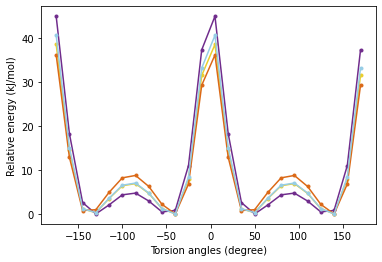

In [12]:
colors = chemi._KELLYS_COLORS
for i in range(4):
    plt.plot(all_angles[i][12:] + all_angles[i][:12], np.concatenate((all_energies[i][12:], all_energies[i][:12])), color=colors[i])
    plt.plot(all_angles[i][12:] + all_angles[i][:12], np.concatenate((all_energies[i][12:], all_energies[i][:12])), '.', color=colors[i])
plt.xlabel('Torsion angles (degree)')
plt.ylabel('Relative energy (kJ/mol)')
plt.savefig('biphenyl_mm_torsion_scan.pdf', bbox_inches='tight')

In [13]:
# Get a system
integrator = mm.VerletIntegrator(1*unit.femtosecond)
platform = mm.Platform.getPlatformByName("Reference")

simulation = simulations[0]
xyz = off_molecules[0].conformers[0].in_units_of(unit.nanometer)
simulation.context.setPositions(xyz)
flat_xyz = (xyz / unit.nanometer).flatten()

In [14]:
fxn_to_minimize(flat_xyz, simulation), jacobian_of_fxn(flat_xyz, simulation)

(387.15155029296875,
 array([[  512.05950928,  -267.55859375,  -463.58807373],
        [  627.47070312,  -336.04086304,  -258.81332397],
        [ -274.18374634,   151.41256714,   -53.90879822],
        [  -55.53871918,    24.17018318,   216.37582397],
        [ -774.40844727,   501.77178955,  -255.8913269 ],
        [ -272.22390747,    56.24277878,   910.92425537],
        [-1039.71337891,   538.46478271,   678.17028809],
        [-1057.34436035,   570.0526123 ,   631.75488281],
        [ -352.51321411,   189.51737976,   217.09680176],
        [  666.59411621,  -359.22131348,  -419.15808105],
        [  408.62506104,  -219.37353516,  -256.40472412],
        [ 1291.38452148,  -682.84436035,  -810.90246582],
        [  120.70637512,   -62.97424316,   -73.27740479],
        [ 1100.31445312,  -430.5269165 ,  -592.0189209 ],
        [  937.62695312,  -654.86444092,  -674.35327148],
        [   36.8917923 ,   -16.82372665,   -79.7412262 ],
        [  -21.63752747,    11.07032013,    26.8580

In [15]:
target_dihedral = 0
torsion_indices = dih
eq_cons = form_eq_constraint(torsion_indices, target_dihedral)
eq_cons['jac'](flat_xyz)

array([ -3.9966948 ,  -7.24618613,  -0.23349414,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         4.29775471,   7.0672432 ,   0.8681694 ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         7.99896673,  14.15260393,   0.76520708,  -8.30002664,
       -13.973661  ,  -1.39988234,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [16]:
eq_cons

{'type': 'eq',
 'fun': functools.partial(<function dihedral_constraint at 0x7f973713c440>, torsion_indices=[0, 8, 9, 4], target_dihedral=0),
 'jac': <function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f(*args, **kwargs)>}

In [17]:
from scipy.optimize import show_options
show_options('minimize', method='SLSQP')

Minimize a scalar function of one or more variables using Sequential
Least SQuares Programming (SLSQP).

Options
-------
ftol : float
    Precision goal for the value of f in the stopping criterion.
eps : float
    Step size used for numerical approximation of the Jacobian.
disp : bool
    Set to True to print convergence messages. If False,
    `verbosity` is ignored and set to 0.
maxiter : int
    Maximum number of iterations.


## Production Run

In [20]:
from simtk import openmm, unit
from dask.delayed import delayed

In [21]:
forcefield = ForceField('openff-1.0.0.offxml')

In [22]:
off_molecules

[Molecule with name 'neutral' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])O[H])[H]',
 Molecule with name 'cation' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])O[H])[H]',
 Molecule with name 'anion' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])[O-])[H]',
 Molecule with name 'zwitterion' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])[O-])[H]']

In [23]:
dihedrals

[[0, 8, 9, 4], [0, 8, 9, 4], [0, 8, 9, 4], [0, 8, 9, 4]]

In [24]:
def create_openmm_system(offmol, forcefield):
    
    top = Topology.from_molecules(offmol)
    system = forcefield.create_openmm_system(top)
    
    integrator = mm.VerletIntegrator(1*unit.femtosecond)
    platform = mm.Platform.getPlatformByName("Reference")
    simulation = openmm.app.Simulation(top, 
                                       system, 
                                       integrator=integrator,
                                       platform=platform)
    return simulation
    
def optimize_geometry(index, offmol, forcefield, dihedral):
    
    simulation = create_openmm_system(offmol, forcefield)
    xyz = offmol.conformers[index].in_units_of(unit.nanometer)
    simulation.context.setPositions(xyz)

    angle = torsions.measure_dihedral_angle(coords=xyz._value, dihedral=dihedral)
    flat_xyz = (xyz / unit.nanometer).flatten()

    target_dihedral = (angle) *np.pi/180
    print(angle)
    print(target_dihedral)

    # jiggle xyz
    minimum = get_energy(xyz, simulation)

    print('initial_energy: {}'.format(minimum))
    for i in range(5):
        flat_xyz = flat_xyz + np.random.normal(0, 0.01, flat_xyz.shape)

        new_result = minimize(fxn_to_minimize, flat_xyz, simulation, method='SLSQP', jac=jacobian_of_fxn,
           constraints=[form_eq_constraint(dihedral, target_dihedral)],
                        options={'ftol': 1e-10, 'disp': True, 'maxiter': 8000})

        minimum = min(minimum, new_result.fun)

        if new_result.fun == minimum:
            result = new_result

    print('final_energy: {}'.format(result.fun))
    return result

def run_torsiondrive(offmol, forcefield, dihedral):
    results = []
    for j in range(24):
        result = delayed(optimize_geometry)(j, offmol, forcefield, dihedral)
        results.append(result)
    return delayed(results).compute(scheduler="processes")

### Compute

In [25]:
%%time
prod_energies = []

for offmol, dihedral in zip(off_molecules, dihedrals):
    print(f"Processing {offmol} with dihedral indices {dihedral}")
    prod_energies.append(run_torsiondrive(offmol, forcefield, dihedral))

Processing Molecule with name 'neutral' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])O[H])[H]' with dihedral indices [0, 8, 9, 4]
Processing Molecule with name 'cation' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])O[H])[H]' with dihedral indices [0, 8, 9, 4]
Processing Molecule with name 'anion' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])[O-])[H]' with dihedral indices [0, 8, 9, 4]
Processing Molecule with name 'zwitterion' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])[O-])[H]' with dihedral indices [0, 8, 9, 4]
CPU times: user 22.4 s, sys: 2.53 s, total: 24.9 s
Wall time: 1h 52s


## Final Plots

In [26]:
energies_1 = [i.fun for i in prod_energies[0]]
energies_1 = energies_1[12:] + energies_1[:12]
energies_2 = [i.fun for i in prod_energies[1]]
energies_2 = energies_2[12:] + energies_2[:12]
energies_3 = [i.fun for i in prod_energies[2]]
energies_3 = energies_3[12:] + energies_3[:12]
energies_4 = [i.fun for i in prod_energies[3]]
energies_4 = energies_4[12:] + energies_4[:12]

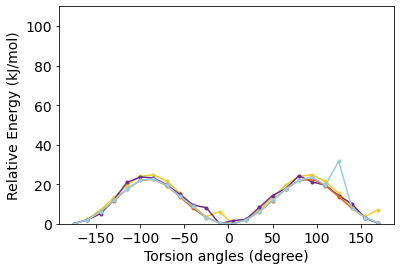

In [27]:
plt.plot(angles[12:]+angles[:12], np.asarray(energies_1)-min(energies_1), '.', color=colors[0])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_1)-min(energies_1), color=colors[0])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_2)-min(energies_2), '.', color=colors[1])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_2)-min(energies_2), color=colors[1])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_3)-min(energies_3), '.', color=colors[2])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_3)-min(energies_3), color=colors[2])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_4)-min(energies_4), '.', color=colors[3])
plt.plot(angles[12:]+angles[:12], np.asarray(energies_4)-min(energies_4), color=colors[3])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Torsion angles (degree)', fontsize=14)
plt.ylabel('Relative Energy (kJ/mol)', fontsize=14)
plt.ylim(0, 110)
plt.savefig('biphenyl_mm_min_torsion_scan.pdf', bbox_inches='tight')